# Programming assignment 09: Deep Learning

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

## Your Task

In this notebook, the skeleton for learning a feed-forward neural network is given. Your task is to complete the functions where required.

## Submission

**Submit your notebook by January 6, 2019** as a .html file with your code and the respective cell outputs.

You can also take part in our challenge to fit the best model to the cell phone data by submitting your predictions for the test data. The winners of the challenge will be announced after the Christmas break! See the bottom of this file for more information.

## Load and Preprocess Data

I this assignment we will work with a dataset containing accelerometer and gyroscope sensor signals of a cell-phone. Given the sensor signals, the task is to predict the activity that the cell-phone user is doing, e.g, running, walking, biking, or moving upstairs.

The data consists of 8032 samples. Each feature vector contains 6 measurements from the cell-phone sensors in 20 consequent time steps. Indeed, each feature vector is 120-dimensional. The task is to classify these instances into the following classes: "Walking", "Standing", "Sitting", "Running", "Upstairs", "Downstairs".

More details can be found here: https://becominghuman.ai/deep-learning-for-sensor-based-human-activity-recognition-970ff47c6b6b 

**Before you start** download the data from https://syncandshare.lrz.de/dl/fiXnRq4MRd8fGJBXH2jQmNcN/homework_09_data.npz and place the file into the same directory as this notebook.

In [2]:
loader = np.load("homework_09_data.npz")
train_data = loader['train_data']
train_labels = loader['train_labels']

val_data = loader['val_data']
val_labels = loader['val_labels']

test_data = loader['test_data']


The skeleton of the class ```FeedForwardNet``` is provided in the following. This class implements a feed-forward neural network in Tensorflow. 
**Your task** is to complete the parts where it says ```### YOUR CODE HERE ###```. 

To complete the code properly, make sure that you make the computation graph based on the placeholders ```self.X``` and ```self.Y```. These two placeholders are created in the `build` function; you don't need to create them. You only need to use them.
* ```self.X```: a placeholder of shape ```[None,D]``` where the none dimension will be replaced by the number of instances, and $D$ is number of features.
* ```self.Y```: a placeholder of shape ```[None,K]``` where the none dimension will be replaced by the number of instances, and $K$ is number of classes.



In [3]:
def batch_data(num_data, batch_size):
    """ Yield batches with indices until epoch is over.
    
    Parameters
    ----------
    num_data: int
        The number of samples in the dataset.
    batch_size: int
        The batch size used using training.

    Returns
    -------
    batch_ixs: np.array of ints with shape [batch_size,]
        Yields arrays of indices of size of the batch size until the epoch is over.
    """
    
    data_ixs = np.random.permutation(np.arange(num_data))
    ix = 0
    while ix + batch_size < num_data:
        batch_ixs = data_ixs[ix:ix+batch_size]
        ix += batch_size
        yield batch_ixs
    

class FeedForwardNet:
    """
    Simple feed forward neural network class
    """
    
    def __init__(self, hidden_sizes, layer_types, name, l2_reg=0.0):
        """ FeedForwardNet constructor.
        
        Parameters
        ----------
        hidden_sizes: list of ints
            The sizes of the hidden layers of the network.
        name: str
            The name of the network (used for a VariableScope)
        l2_reg: float
            The strength of L2 regularization (0 means no regularization)
        """
        
        self.hidden_sizes = hidden_sizes
        self.layer_types = layer_types
        self.name = name
        self.dropout = tf.placeholder_with_default(0.0, shape=(), name="dropout")
        self.l2_reg = l2_reg
        self.weights =[]
        self.biases =[]
    
    def build(self, data_dim, num_classes):
        """ Construct the model.
        
        Parameters
        ----------
        data_dim: int
            The dimensions of the data samples.

        Returns
        -------
        None

        """
        self.X = tf.placeholder(shape=[None, data_dim], dtype=tf.float32, name="data") #[NxD]
        self.Y = tf.placeholder(shape=[None, num_classes], dtype=tf.float32, name="labels") #[Nx1]
    
        with tf.variable_scope(self.name):
        
            hidden = self.X

            for ix, hidden_size in enumerate(self.hidden_sizes):
                W = tf.get_variable(f"W_{ix}", [hidden.shape[1], hidden_size])
                b = tf.get_variable(f"b_{ix}", [hidden_size])                
                self.weights.append(W)
                self.biases.append(b)
                hidden = tf.nn.dropout(self.layer_types[ix](hidden @ W + b), 1 - self.dropout)
                
                    
            W_last = tf.get_variable("W_last", shape = [hidden.shape[1], num_classes])
            b_last = tf.get_variable("b_last", shape = [num_classes])
            self.weights.append(W_last)
            self.biases.append(b_last)
            
            self.logits = hidden @ W_last + b_last
            self.l2_norm = tf.add_n([tf.norm(w) for w in self.weights]) 
            self.cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.Y,
                                                                                                logits = self.logits))
            self.predictions = tf.argmax(self.logits, axis = 1)
            self.int_labels = tf.argmax(self.Y, axis = 1)
            self.accuracy = tf.reduce_mean(tf.cast(tf.math.equal(self.predictions, self.int_labels),tf.float32),name = "accuracy_")

            self.loss = self.cross_entropy_loss + self.l2_reg * self.l2_norm
            
            self.optimizer = tf.train.AdamOptimizer()
            self.opt_op = self.optimizer.minimize(self.loss, var_list=[*self.weights, *self.biases])
        
    def train(self, train_data, train_labels, val_data, val_labels, epochs=20, dropout=0.0, batch_size=512):
        """ Train the feed forward neural network.
        
        Parameters
        ----------
        train_data: np.array, dtype float32, shape [N, D]
            The training data. N corresponds to the number of training samples, D to the dimensionality of the data samples/
        train_labels: np.array, shape [N, K]
            The labels of the training data, where K is the number of classes.
        val_data: np.array, dtype float32, shape [N_val, D]
            The validation data. N_val corresponds to the number of validation samples, D to the dimensionality of the data samples/
        val_labels: np.array, shape [N_val, K]
            The labels of the training data, where K is the number of classes.
        epochs: int
            The number of epochs to train for.
        dropout: float
            The dropout rate used during training. 0 corresponds to no dropout.
        batch_size: int
            The batch size used for training.

        Returns
        -------
        None

        """
        train_losses = []
        train_accs = []
        val_losses = []
        val_accs = []
        
        self.session = tf.Session()
        session = self.session
        
        with session.as_default():
            session.run(tf.global_variables_initializer())
            tr_loss, tr_acc= session.run([self.loss, self.accuracy], feed_dict={self.X:train_data, 
                                                                                self.Y: train_labels})
            val_loss, val_acc= session.run([self.loss, self.accuracy], feed_dict={self.X:val_data, 
                                                                                self.Y: val_labels})
            train_losses.append(tr_loss)
            train_accs.append(tr_acc)
            
            val_losses.append(val_loss)
            val_accs.append(val_acc)
                        
            for epoch in range(epochs):
                if (epoch + 1) % 25 == 0:
                    print(f"Epoch {epoch+1}/{epochs}")
                for batch_ixs in batch_data(len(train_data), batch_size):
                    _ = session.run(self.opt_op, feed_dict={self.X: train_data[batch_ixs],
                                                            self.Y: train_labels[batch_ixs]})
                    
                tr_loss, tr_acc = session.run([self.loss, self.accuracy], feed_dict={self.X:train_data, 
                                                                                self.Y: train_labels})
                val_loss, val_acc = session.run([self.loss, self.accuracy], feed_dict={self.X:val_data, 
                                                                                self.Y: val_labels})
                train_losses.append(tr_loss)
                train_accs.append(tr_acc)

                val_losses.append(val_loss)
                val_accs.append(val_acc)    

        self.hist={'train_loss': np.array(train_losses),
           'train_accuracy': np.array(train_accs),
           'val_loss': np.array(val_losses),
           'val_accuracy': np.array(val_accs)}

## Building a Feed-forward Neural Network

In this part, specify the FFNN. To do so, you can set the following fields in the next cell:
* ```hidden_sizes```: a list that contains the number of hidden neurons in different layers.
* ```layer_types```: a list containing the activation functions of the layers. 

For instance, the values of the following cell specify a FFNN having 3 ReLU layers and a softmax layer. Note that we do not explicitly mention 'softmax'; Because we know that for the classification task, the last layer is softmax. Moreover, we do not specify $D$ and $K$ in the variable ```hidden_sizes```, because we know that the first layer has $D$ neurons and the last layer has $K$ neurons. 


You can change the configuration of the network. The sample solution is built by the following configuration.


Let's start without any regularization. You can set the values ```num_epochs``` and ```batch_size``` in the following cell.

In [4]:
#You can change layer types and the number of neurons by changing the following variables.
layer_types = [tf.nn.relu, tf.nn.relu, tf.nn.relu]
hidden_sizes = [16, 8, 4]
epochs = 200
batch_size = 512


## Training the Network Using Different Regularizations

In this part, we learn the neural network in three different settings:
* Without any regularization
* With $\ell 2$ regularization
* With dropout

For each case, we are going to see how the training/validation/test losses will change during training.

In [5]:
NN_no_regularization = FeedForwardNet(hidden_sizes, layer_types, "no_regularization")
NN_no_regularization.build(train_data.shape[1], num_classes=train_labels.shape[1])

In [6]:
NN_no_regularization.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Epoch 25/200
Epoch 50/200
Epoch 75/200
Epoch 100/200
Epoch 125/200
Epoch 150/200
Epoch 175/200
Epoch 200/200


#### Plot the training and validation losses over the epochs. What do you notice?

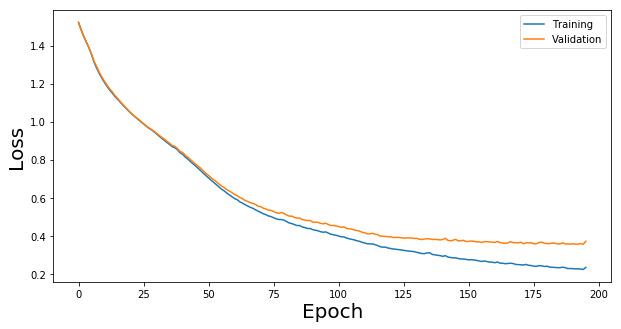

In [7]:
plt.figure(figsize=(10,5))
plt.plot(NN_no_regularization.hist['train_loss'][5::], label="Training")
plt.plot(NN_no_regularization.hist['val_loss'][5::], label="Validation")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

#### Now plot the training and validation accuracies over the epochs.

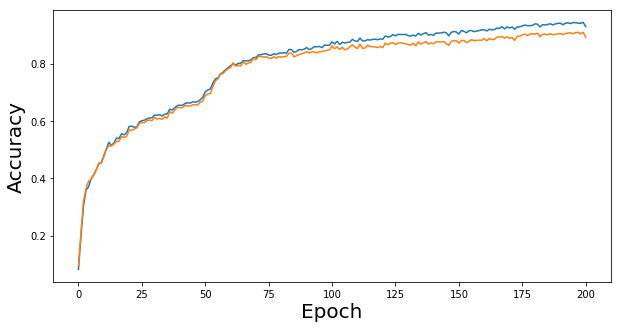

In [8]:
plt.figure(figsize=(10,5))

plt.plot(NN_no_regularization.hist['train_accuracy'])
plt.plot(NN_no_regularization.hist['val_accuracy'])

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)

plt.show()

### $\ell 2$ regularization

Afterwards, we use $\ell 2$ regularization, and we investigate the train/validation/test loss. Set the regularization parameter to 0.01.

In [9]:
NN_L2_regularization = FeedForwardNet(hidden_sizes, layer_types, "L2_regularization", l2_reg=1e-2)
NN_L2_regularization.build(train_data.shape[1], num_classes=train_labels.shape[1])

In [10]:
NN_L2_regularization.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size)

Epoch 25/200
Epoch 50/200
Epoch 75/200
Epoch 100/200
Epoch 125/200
Epoch 150/200
Epoch 175/200
Epoch 200/200


### Dropout

Finally, we train a model using dropout. Use a dropout rate of 0.5.

In [11]:
NN_dropout_regularization = FeedForwardNet(hidden_sizes, layer_types, "dropout_regularization")
NN_dropout_regularization.build(train_data.shape[1], num_classes=train_labels.shape[1])

In [12]:
NN_dropout_regularization.train(train_data, train_labels, val_data, val_labels, epochs,
                          batch_size=batch_size, dropout=0.5)

Epoch 25/200
Epoch 50/200
Epoch 75/200
Epoch 100/200
Epoch 125/200
Epoch 150/200
Epoch 175/200
Epoch 200/200


## Comparing the models
Now, compare the final training and validation losses achieved by the different models.

In [13]:
train_acc_noreg = NN_no_regularization.hist['train_accuracy'][-1]
val_acc_noreg = NN_no_regularization.hist['val_accuracy'][-1]

train_acc_L2reg = NN_L2_regularization.hist['train_accuracy'][-1]
val_acc_L2reg = NN_L2_regularization.hist['val_accuracy'][-1]

train_acc_dropoutreg = NN_dropout_regularization.hist['train_accuracy'][-1]
val_acc_dropoutreg = NN_dropout_regularization.hist['val_accuracy'][-1]

In [14]:
print(f"Training accuracy without regularization: {train_acc_noreg:.3f}")
print(f"Validation accuracy without regularization: {val_acc_noreg:.3f}")
print()

print(f"Training accuracy with L2 regularization: {train_acc_L2reg:.3f}")
print(f"Validation accuracy with L2 regularization: {val_acc_L2reg:.3f}")
print()

print(f"Training accuracy with dropout regularization: {train_acc_dropoutreg:.3f}")
print(f"Validation accuracy with dropout regularization: {val_acc_dropoutreg:.3f}")

Training accuracy without regularization: 0.929
Validation accuracy without regularization: 0.891

Training accuracy with L2 regularization: 0.935
Validation accuracy with L2 regularization: 0.909

Training accuracy with dropout regularization: 0.935
Validation accuracy with dropout regularization: 0.887


### Plot the losses and accuracies of the models in one plot to compare them.

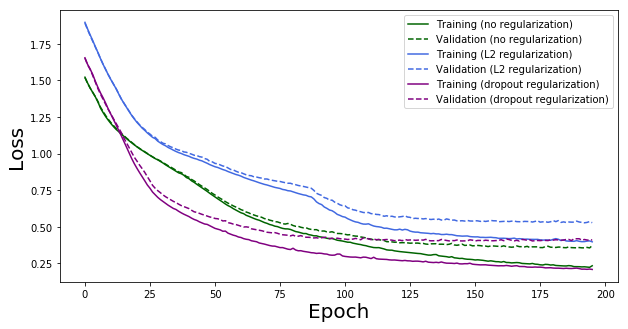

In [15]:
plt.figure(figsize=(10,5))
plt.plot(NN_no_regularization.hist['train_loss'][5::], label="Training (no regularization)",
        color="darkgreen")
plt.plot(NN_no_regularization.hist['val_loss'][5::], label="Validation (no regularization)",
        color="darkgreen", linestyle="--")

plt.plot(NN_L2_regularization.hist['train_loss'][5::], label="Training (L2 regularization)",
        color="royalblue")
plt.plot(NN_L2_regularization.hist['val_loss'][5::], label="Validation (L2 regularization)",
        color="royalblue", linestyle="--")

plt.plot(NN_dropout_regularization.hist['train_loss'][5::], 
         label="Training (dropout regularization)", color="purple")
plt.plot(NN_dropout_regularization.hist['val_loss'][5::], 
         label="Validation (dropout regularization)", color="purple", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.legend()
plt.show()

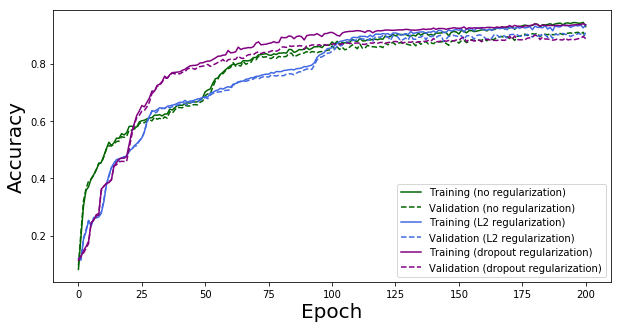

In [16]:
plt.figure(figsize=(10,5))

plt.plot(NN_no_regularization.hist['train_accuracy'], label="Training (no regularization)",
        color="darkgreen")
plt.plot(NN_no_regularization.hist['val_accuracy'], label="Validation (no regularization)",
        color="darkgreen", linestyle="--")

plt.plot(NN_L2_regularization.hist['train_accuracy'], label="Training (L2 regularization)",
        color="royalblue")
plt.plot(NN_L2_regularization.hist['val_accuracy'], label="Validation (L2 regularization)",
        color="royalblue", linestyle="--")

plt.plot(NN_dropout_regularization.hist['train_accuracy'], 
         label="Training (dropout regularization)", color="purple")
plt.plot(NN_dropout_regularization.hist['val_accuracy'], 
         label="Validation (dropout regularization)", color="purple", linestyle="--")

plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.legend()
plt.show()

## Challenge

Notice that we also have the variable `test_data`. **Get creative** and build a model yourself!

Submit your predictions of the test data to Moodle to enter the leaderboard. We will announce the winning team after the Christmas break!

You can output the predictions of the test data using:

In [ ]:
test_preds = YOUR_NN_MODEL.logits.eval({YOUR_NN_MODEL.X: test_data},
                                        session=YOUR_NN_MODEL.session).argmax(1)

We will only consider submission as plain text files with **exactly** the following formatting as our `sample_submission.txt`

In [ ]:
string = ""
with open("sample_submission.txt", "r") as f:
    string = f.read()
print(string[:19])
print("...")

You can use the following command to save your predictions:

In [ ]:
np.savetxt("your_submission.txt", test_preds, fmt='%i')